In [1]:
# using Pkg
# Pkg.activate("..") 
# Pkg.instantiate()
using JPEC, Plots
gr() 

Plots.GRBackend()

In [2]:
using LinearAlgebra
using Printf
using Plots

### read Equil

In [3]:
# 1. Define the input parameters for the equilibrium solver.
#    - eq_filename: The name of the g-file we just created.
#    - eq_type: "efit" for a standard g-file.
#    - jac_type: "boozer" or "hamada" for the output coordinates.
#    - mpsi, mtheta: Resolution of the output grid.
equil_input = JPEC.Equilibrium.EquilInput(
    "beta_1.00",        # eq_filename
    "efit",          # eq_type
    "boozer",        # jac_type
    0.01,             # psilow
    1.0,             # psihigh
    100,             # mpsi (number of radial grid points)
    128              # mtheta (number of poloidal grid points)
)

# 2. Run the main equilibrium setup function.
#    This will read the file, solve the direct problem, and return the final object.
println("Starting equilibrium reconstruction...")
plasma_eq = JPEC.Equilibrium.setup_equilibrium(equil_input)
println("Equilibrium reconstruction complete.")

Starting equilibrium reconstruction...
--- Julia Equilibrium Setup ---
Equilibrium file: beta_1.00
Type = efit, Jac_type = boozer
----------------------------------------
--> Processing EFIT g-file: beta_1.00
--> Parsed from header: nw=129, nh=128
--> All main data blocks parsed successfully.
--> Creating 1D profile splines...
--> 1D Spline fitting complete.
--> Creating 2D psi spline...
--> 2D Spline fitting complete.
--- Starting Direct Equilibrium Processing ---
Finding magnetic axis...
  Iter  1: R = 3.115238, Z = 0.000008, |ΔR|=1.15e-01, |ΔZ|=1.11e-05
  Iter  2: R = 3.117635, Z = -0.000003, |ΔR|=2.40e-03, |ΔZ|=1.10e-05
  Iter  3: R = 3.117636, Z = -0.000003, |ΔR|=1.07e-06, |ΔZ|=1.04e-09
  Iter  4: R = 3.117636, Z = -0.000003, |ΔR|=2.12e-13, |ΔZ|=5.62e-16
Magnetic axis found at R=3.1176357129137466, Z=-2.9184696943092166e-6.
JPEC.SplinesMod.Helper.ReadOnlyArray{Float64, 1, Vector{Float64}}JPEC.SplinesMod.Helper.ReadOnlyArray{Float64, 1, Vector{Float64}}Array{Float64, 3}Finding inbo

### Use spline_eval 
sq!!

In [4]:
# The plasma_eq object contains the final 1D profile spline, `sq`.
# We will evaluate it on a fine grid to get smooth plot lines.
psi_norm_grid = range(0.0, 1.0, length=200)

# spline_eval returns the function values (and derivatives if requested).
# For sq, the quantities are: 1:F, 2:P*mu0, 3:Toroidal Flux, 4:q
f_profiles = JPEC.SplinesMod.spline_eval(plasma_eq.sq, collect(psi_norm_grid))

# Extract each profile into its own variable for clarity
F_profile      = f_profiles[:, 1]
P_profile      = f_profiles[:, 2]
tor_flux_prof  = f_profiles[:, 3]
q_profile      = f_profiles[:, 4];

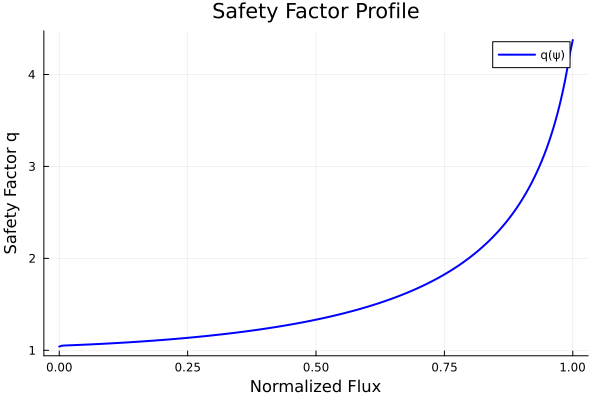

In [5]:
plot(psi_norm_grid, q_profile, 
     xlabel="Normalized Flux", ylabel="Safety Factor q", 
     title="Safety Factor Profile",
     legend=:topright, label="q(ψ)", lw=2, color=:blue)

In [ ]:
"""
    sing_find!(sing_surf_data, plasma_eq; mex=2, nn=1, itmax=200)

Finds and appends rational (singular) surfaces in a plasma equilibrium profile,
where `m = nn*q` within each interval between extrema of the safety factor profile `q(ψ)`.

The results are stored as `NamedTuple`s in the supplied vector `sing_surf_data`, 
with keys: `m`, `ψfac`, `ρ`, `q`, and `q1`.

# Arguments
- `sing_surf_data::Vector`: Container for output; will be emptied and updated in-place.
- `plasma_eq`: Plasma equilibrium object with a field `.sq` suitable for spline evaluation.
- `mex::Int`: Number of `q` profile extrema. Defaults to 2 (monotonic `q`).
- `nn::Int`: Toroidal mode number `n`.
- `itmax::Int`: Maximum allowed bisection iterations per root.

# Details
Searches each interval between adjacent `q`-profile extrema for all integer poloidal mode numbers `m`
that satisfy the rational surface condition `m = n*q(ψ)`, using bisection to find the roots.
Assumes a monotonic `q` profile, unless a generalized interface is implemented
(TODO: support for non-monotonic profiles).

# Output
For each rational surface found, a `NamedTuple` with:
- `m`: Poloidal mode number at this surface
- `ψfac`: Normalized flux label at the surface
- `ρ`: Square root of `ψfac`
- `q`: `q` value at the surface (`m/nn`)
- `q1`: Derivative of `q` at the surface

is pushed to `sing_surf_data`.
"""
function sing_find!(sing_surf_data, plasma_eq; nn=1, itmax=200)
    
    # Ensure sing_surf_data is empty before starting
    empty!(sing_surf_data)

    # Define functions to evaluate q and its first derivative
    qval(ψ) = JPEC.SplinesMod.spline_eval(plasma_eq.sq, ψ, 0)[4]
    q1val(ψ) = JPEC.SplinesMod.spline_eval(plasma_eq.sq, ψ, 1)[2][4] 

    # TODO: I assume monotonic here for checking, will need to provide some interface
    #  for the actual values fo (mex, qex) determined from the equil code
    qex = [qval(0.0), qval(1.0)]
    ψex = [0.0, 1.0]
    mex = 2

    # Loop over extrema of q, find all rational values in between
    for iex in 2:mex
        dq = qex[iex] - qex[iex-1]
        m = floor(Int, nn * qex[iex-1])
        if dq > 0
            m += 1
        end
        dm = Int(sign(dq * nn))

        # Loop over possible m's in interval
        while (m - nn * qex[iex-1]) * (m - nn * qex[iex]) <= 0
            it = 0
            ψ0 = ψex[iex-1]
            ψ1 = ψex[iex]
            ψfac = 0.0

            # Bisection method to find singular surface
            while it < itmax
                it += 1
                ψfac = (ψ0 + ψ1)/2
                singfac = (m - nn * qval(ψfac)) * dm
                if abs(singfac) <= 1e-12
                    break
                elseif singfac > 0
                    ψ0 = ψfac
                else
                    ψ1 = ψfac
                end
            end
            if it == itmax
                @warn "Bisection did not converge for m = $m"
                # You may want to continue, break, or error here
            else
                push!(sing_surf_data, (
                    m = m,
                    ψfac = ψfac,
                    ρ = sqrt(ψfac),
                    q = m / nn,
                    q1 = q1val(ψfac),
                ))
            end
            m += dm
        end
    end
end

sing_find!

In [8]:
sing_surf_data = []
sing_find!(sing_surf_data, plasma_eq)

In [9]:
sing_surf_data

3-element Vector{Any}:
 (m = 2, ψfac = 0.7971154589113212, ρ = 0.8928132273389106, q = 2.0, q1 = 4.2200821839498985)
 (m = 3, ψfac = 0.9349981473227444, ρ = 0.9669530222936089, q = 3.0, q1 = 12.802584250560939)
 (m = 4, ψfac = 0.9872146757753626, ρ = 0.993586773148356, q = 4.0, q1 = 29.52330440934896)